[캐글] https://www.kaggle.com/competitions/tmdb-box-office-prediction

## 라이브러리 로드

In [1]:
# pip install catboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import catboost as cb
from catboost import CatBoostRegressor

# 한글폰트
import koreanize_matplotlib

## 파일 로드 및 미리보기

In [3]:
base_path = "data/box-office"

train = pd.read_csv(f"{base_path}/train.csv")
test = pd.read_csv(f"{base_path}/test.csv")
submission = pd.read_csv(f"{base_path}/sample_submission.csv")

train.shape, test.shape, submission.shape

((3000, 23), (4398, 22), (4398, 2))

In [4]:
display(train.head(2))
display(test.head(2))
display(submission.head(2))

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."


,id,revenue
0,3001,1000000
1,3002,1000000


## 파일 요약정보 보기

In [5]:
# info

print("train: ")
print(train.info())
print("=" * 30)
print("test: ")
print(test.info())

train: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 

In [6]:
# nunique (범주형 OR 수치형)

print("train: ")
print(train.nunique())
print("=" * 30)
print("test: ")
print(test.nunique())

train: 
id                       3000
belongs_to_collection     422
budget                    406
genres                    872
homepage                  941
imdb_id                  3000
original_language          36
original_title           2975
overview                 2992
popularity               2999
poster_path              2999
production_companies     2383
production_countries      321
release_date             2398
runtime                   139
spoken_languages          401
status                      2
tagline                  2400
title                    2969
Keywords                 2648
cast                     2975
crew                     2984
revenue                  2850
dtype: int64
test: 
id                       4398
belongs_to_collection     556
budget                    511
genres                   1101
homepage                 1402
imdb_id                  4398
original_language          39
original_title           4353
overview                 4383
popularity  

In [7]:
# 결측치
print("train: ")
print(train.isnull().sum())
print("=" * 30)
print("test: ")
print(test.isnull().sum())

train: 
id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64
test: 
id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity  

In [8]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [9]:
test.describe()

,id,budget,popularity,runtime
count,4398.000000,4.398000e+03,4398.000000,4394.000000
mean,5199.500000,2.264929e+07,8.550230,107.622212
std,1269.737571,3.689991e+07,12.209014,21.058290
min,3001.000000,0.000000e+00,0.000001,0.000000
25%,4100.250000,0.000000e+00,3.895186,94.000000
50%,5199.500000,7.450000e+06,7.482242,104.000000
75%,6298.750000,2.800000e+07,10.938524,118.000000
max,7398.000000,2.600000e+08,547.488298,320.000000


## 전처리

### collection 

In [10]:
train['has_collection'] = 0
train.loc[train["belongs_to_collection"].isnull() == False , 'has_collection'] = 1

test['has_collection'] = 0
test.loc[test['belongs_to_collection'].isnull() == False, 'has_collection'] = 1

### budget

In [11]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

### homepage

In [12]:
train['has_homepage'] = 0
train.loc[train["homepage"].isnull() == False , 'has_homepage'] = 1

test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

### 장르
5번째 장르까지 표시할 예정

#### train

In [13]:
def make_genres(order, index):
    order_gen = []
    
    for i in tqdm(range(3000)):
        try:
            a = "".join(train["genres"].str.split(",")[i][index]).split(":")[1].split("\'")[1]
        except:
            a = 0
        order_gen.append(a)
    return order_gen

In [14]:
train["first_genres"] = make_genres("first", 1)
train["second_genres"] = make_genres("second", 3)
train["third_genres"] = make_genres("third", 5)

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:03<00:00, 836.06it/s]


In [15]:
train[["genres", "first_genres", "second_genres", "third_genres"]].sample(5)

,genres,first_genres,second_genres,third_genres
1929,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",Drama,Romance,0
952,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Romance,Comedy,0
2712,"[{'id': 53, 'name': 'Thriller'}, {'id': 878, '...",Thriller,Science Fiction,Mystery
2848,"[{'id': 10402, 'name': 'Music'}, {'id': 18, 'n...",Music,Drama,0
2880,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",Action,Drama,Thriller


머신러닝 적용을 위해 장르명(문자형)을 장르코드(숫자)로 바꿔줌

In [16]:
print("순서별 장르의 nunique 값")
print(train["first_genres"].nunique(), train["second_genres"].nunique(), train["third_genres"].nunique())
      
print("=" * 30)
      
print("second:", set(train["first_genres"]) - set(train["second_genres"]))
print("third:", set(train["first_genres"]) - set(train["third_genres"]))

순서별 장르의 nunique 값
21 20 20
second: {'TV Movie'}
third: {'TV Movie'}


In [17]:
train["first_genres"].unique()

# 하드코딩
genres_code = {0:0, 'Comedy':1, 'Drama':2, 'Thriller':3, 'Action':4, 
               'Animation':5, 'Horror':6, 'Documentary':7, 'Adventure':8, 
               'Crime':9, 'Mystery':10, 'Fantasy':11, 'War':12,
               'Science Fiction':13, 'Romance':14, 'Music':15, 'Western':16, 
               'Family':17, 'History':18, 'Foreign':19, 'TV Movie':20}

In [18]:
train["first_genres_code"] = train["first_genres"].apply(lambda x : genres_code[x])
train["second_genres_code"] = train["second_genres"].apply(lambda x : genres_code[x])
train["third_genres_code"] = train["third_genres"].apply(lambda x : genres_code[x])

#### test

In [19]:
# test에도 동일하게 처리해준다.
def make_genres(order, index):
    order_gen = []
    
    for i in tqdm(range(4398)):
        try:
            a = "".join(test["genres"].str.split(",")[i][index]).split(":")[1].split("\'")[1]
        except:
            a = 0
        order_gen.append(a)
    return order_gen

In [20]:
test["first_genres"] = make_genres("first", 1)
test["second_genres"] = make_genres("second", 3)
test["third_genres"] = make_genres("third", 5)

100%|█████████████████████████████████████████████████████████████████████████████| 4398/4398 [00:08<00:00, 538.09it/s]


In [21]:
test[["genres", "first_genres", "second_genres", "third_genres"]].sample(5)

,genres,first_genres,second_genres,third_genres
232,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",Drama,Comedy,Romance
3667,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",Drama,Romance,0
1765,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",Action,Drama,Mystery
311,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Action,Crime,Drama
781,"[{'id': 53, 'name': 'Thriller'}, {'id': 35, 'n...",Thriller,Comedy,Romance


In [22]:
print("순서별 장르의 nunique 값")
print(test["first_genres"].nunique(), test["second_genres"].nunique(), test["third_genres"].nunique())

print("=" * 30)
print("second:", set(test["first_genres"]) - set(test["second_genres"]))
print("third:", set(test["first_genres"]) - set(test["third_genres"]))

순서별 장르의 nunique 값
20 20 20
second: set()
third: set()


train에서 하드코딩한 값을 test에도 적용하여 장르명을 장르코드로 만들어준다.

In [23]:
test["first_genres_code"] = test["first_genres"].apply(lambda x : genres_code[x])
test["second_genres_code"] = test["second_genres"].apply(lambda x : genres_code[x])
test["third_genres_code"] = test["third_genres"].apply(lambda x : genres_code[x])

#### 사용하지 않을 컬럼 삭제

In [24]:
train = train.drop(columns = ["genres", "first_genres", "second_genres", "third_genres"])
test = test.drop(columns = ["genres", "first_genres", "second_genres", "third_genres"])

train.shape, test.shape, set(train) - set(test)

((3000, 28), (4398, 27), {'revenue'})

### original language

희소한값에 대해서는 기타 처리

In [25]:
train["original_language"].value_counts().nsmallest(40)

id       1
ur       1
el       1
ar       1
nb       1
he       1
mr       1
cs       1
sr       1
vi       1
bn       1
fi       2
te       2
pl       2
ml       2
no       2
hu       3
tr       3
ro       4
fa       5
da       5
pt       6
nl       6
sv       8
ta      16
de      18
zh      19
cn      20
ko      20
it      24
ja      37
hi      42
es      43
ru      47
fr      78
en    2575
Name: original_language, dtype: int64

특정 수치 이하인 것은 기타로 묶어주겠다.

In [26]:
original_language_count = train["original_language"].value_counts()
original_language_under = original_language_count[original_language_count >= 47].index.to_list()
print(original_language_under)

['en', 'fr', 'ru']


#### train

In [27]:
train["original_language_etc"] = train["original_language"]
train.loc[~train["original_language"].isin(original_language_under), "original_language_etc"] = "etc"

train[["original_language", "original_language_etc"]]
train["original_language_etc"].value_counts(), train["original_language_etc"].nunique()

(en     2575
 etc     300
 fr       78
 ru       47
 Name: original_language_etc, dtype: int64,
 4)

#### test

In [28]:
test["original_language_etc"] = test["original_language"]
test.loc[~test["original_language"].isin(original_language_under), "original_language_etc"] = "etc"

test[["original_language", "original_language_etc"]]
test["original_language_etc"].value_counts(), test["original_language_etc"].nunique()

(en     3776
 etc     439
 fr      121
 ru       62
 Name: original_language_etc, dtype: int64,
 4)

#### 사용하지 않을 컬럼 삭제 

In [29]:
train = train.drop(columns = "original_language")
test = test.drop(columns = "original_language")
train.shape, test.shape

((3000, 28), (4398, 27))

### popularity

count    3000.000000
mean        8.463274
std        12.104000
min         0.000001
25%         4.018053
50%         7.374861
75%        10.890983
max       294.337037
Name: popularity, dtype: float64


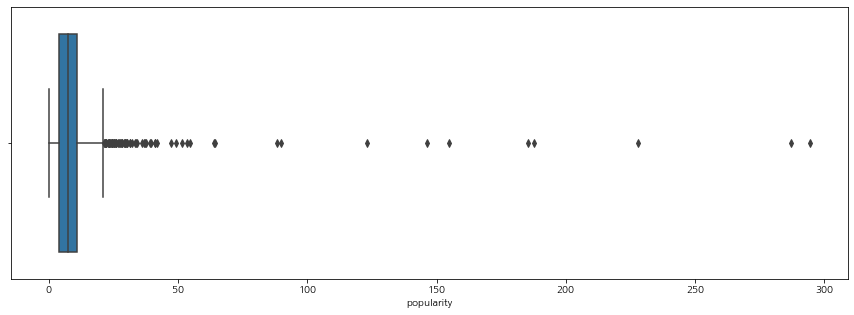

In [30]:
print(train["popularity"].describe())

plt.figure(figsize = (15,5))
sns.boxplot(data = train, x = "popularity");

In [31]:
per_25 = train["popularity"].describe()[4]
per_75 = train["popularity"].describe()[6]

#### train

In [32]:
train.loc[train["popularity"] < per_25, "popularity_class"] = "low"
train.loc[train["popularity"] > per_75, "popularity_class"] = "high"
train["popularity_class"].fillna("median", inplace = True)
train["popularity_class"].value_counts()

median    1500
high       750
low        750
Name: popularity_class, dtype: int64

#### test

In [33]:
test.loc[test["popularity"] < per_25, "popularity_class"] = "low"
test.loc[test["popularity"] > per_75, "popularity_class"] = "high"
test["popularity_class"].fillna("median", inplace = True)
test["popularity_class"].value_counts()

median    2152
low       1133
high      1113
Name: popularity_class, dtype: int64

#### 사용하지 않을 컬럼 삭제

In [34]:
train = train.drop(columns = "popularity")
test = test.drop(columns = "popularity")
train.shape, test.shape

((3000, 28), (4398, 27))

### production_companies
2번째 회사까지 표시할 예정

#### train

In [35]:
def make_company(order, index):
    order_company = []
    
    for i in tqdm(range(3000)):
        try:
            a = "".join(train["production_companies"].str.split(",")[i][index]).split(":")[1].split("\'")[1]
        except:
            a = 0
        order_company.append(a)
    return order_company

In [36]:
train["first_company"] = make_company("first", 0)
train["second_company"] = make_company("second", 2)

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:03<00:00, 848.01it/s]


#### test

In [37]:
def make_company(order, index):
    order_company = []
    
    for i in tqdm(range(4398)):
        try:
            a = "".join(test["production_companies"].str.split(",")[i][index]).split(":")[1].split("\'")[1]
        except:
            a = 0
        order_company.append(a)
    return order_company

In [38]:
test["first_company"] = make_company("first", 0)
test["second_company"] = make_company("second", 2)

100%|█████████████████████████████████████████████████████████████████████████████| 4398/4398 [00:09<00:00, 467.14it/s]


#### 소형, 중대형으로 분류하기

- 4 이하이면 소형, 4초과이면 중대형
- train의 first_comapny 빈도수 기준

In [39]:
first_company_count = train["first_company"].value_counts()
first_company_under = first_company_count[first_company_count > 4].index.to_list()
print(first_company_under)

['Universal Pictures', 'Paramount Pictures', 0, 'Twentieth Century Fox Film Corporation', 'Columbia Pictures', 'Warner Bros.', 'New Line Cinema', 'Walt Disney Pictures', 'TriStar Pictures', 'Columbia Pictures Corporation', 'United Artists', 'Metro-Goldwyn-Mayer (MGM)', 'Miramax Films', 'Fox Searchlight Pictures', 'Touchstone Pictures', 'Village Roadshow Pictures', 'BBC Films', 'Orion Pictures', 'Hollywood Pictures', 'Summit Entertainment', 'Lionsgate', 'DreamWorks SKG', 'Imagine Entertainment', 'StudioCanal', 'Lions Gate Films', 'Fox 2000 Pictures', 'Regency Enterprises', 'Lakeshore Entertainment', 'The Weinstein Company', 'France 2 Cinéma', 'Dune Entertainment', 'Legendary Pictures', 'Cannon Group', 'Castle Rock Entertainment', 'Eon Productions', 'Gaumont', 'WingNut Films', 'Dimension Films', 'American Zoetrope', 'Universal Studios', 'Original Film', 'Lucasfilm', 'Silver Pictures', 'Studio Babelsberg', 'Alcon Entertainment', 'Fine Line Features', 'Screen Gems', 'Channel Four Films', '

In [40]:
train["first_company_class"] = "중대형"
train.loc[~train["first_company"].isin(first_company_under), "first_company_class"] = "소형"

train["second_company_class"] = "중대형"
train.loc[~train["second_company"].isin(first_company_under), "second_company_class"] = "소형"

test["first_company_class"] = "중대형"
test.loc[~test["first_company"].isin(first_company_under), "first_company_class"] = "소형"

test["second_company_class"] = "중대형"
test.loc[~test["second_company"].isin(first_company_under), "second_company_class"] = "소형"

#### 사용하지 않을 컬럼 삭제

In [41]:
train = train.drop(columns = ["first_company","second_company","production_companies"])
test = test.drop(columns = ["first_company","second_company","production_companies"])
train.shape, test.shape

((3000, 29), (4398, 28))

### production_countries

첫번째 국가만 표시할 예정

#### train

In [42]:
def make_country(order, index):
    order_country = []
    
    for i in tqdm(range(3000)):
        try:
            a = "".join(train["production_countries"].str.split(",")[i][index]).split(":")[1].split("\'")[1]
        except:
            a = 0
        order_country.append(a)
    return order_country

In [43]:
train["production_country"]= make_country("first", 0)

100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1049.43it/s]


#### test

In [44]:
def make_country(order, index):
    order_country = []
    
    for i in tqdm(range(4398)):
        try:
            a = "".join(test["production_countries"].str.split(",")[i][index]).split(":")[1].split("\'")[1]
        except:
            a = 0
        order_country.append(a)
    return order_country

In [45]:
test["production_country"]= make_country("first", 0)

100%|█████████████████████████████████████████████████████████████████████████████| 4398/4398 [00:06<00:00, 679.94it/s]


#### 국가 희소값 처리

['US', 'GB']


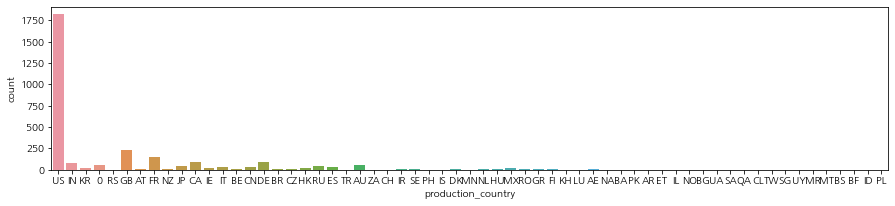

In [46]:
plt.figure(figsize = (15,3))
sns.countplot(data = train, x = "production_country");

production_country_count = train["production_country"].value_counts()
production_country_under = production_country_count[production_country_count >= 150].index.to_list()
print(production_country_under)

In [47]:
production_country_count.nlargest(60)

US    1818
GB     234
FR     147
CA      97
DE      90
IN      78
0       55
AU      52
JP      50
RU      47
IT      36
CN      34
ES      33
HK      20
KR      19
MX      19
IE      17
BE      14
NZ      13
BR      12
DK      11
CZ      10
SE       8
AT       6
HU       6
NL       6
GR       5
AE       5
FI       4
RO       4
IR       4
NO       3
CL       3
ZA       3
CH       2
TR       2
KH       2
LU       2
BS       2
PH       2
UA       2
AR       2
BG       2
IL       2
BF       1
SG       1
MT       1
UY       1
MR       1
ID       1
TW       1
MN       1
QA       1
SA       1
ET       1
PK       1
BA       1
NA       1
IS       1
RS       1
Name: production_country, dtype: int64

In [48]:
train["production_country_etc"] = train["production_country"]
train.loc[~train["production_country"].isin(production_country_under), "production_country_etc"] = "etc"

train[["production_country", "production_country_etc"]]
train["production_country_etc"].value_counts()
train["production_country_etc"].nunique()

test["production_country_etc"] = test["production_country"]
test.loc[~test["production_country"].isin(production_country_under), "production_country_etc"] = "etc"

test[["production_country", "production_country_etc"]]
test["production_country_etc"].value_counts()
test["production_country_etc"].nunique()

3

#### 사용하지 않을 컬럼 삭제 

In [49]:
train = train.drop(columns = ["production_countries", "production_country"])
test = test.drop(columns = ["production_countries", "production_country"])
train.shape, test.shape

((3000, 29), (4398, 28))

### release_date

In [50]:
train["release_date"] = train["release_date"].fillna(0)
test["release_date"] = test["release_date"].fillna(0)

#### train 

In [51]:
train["release_date"] = pd.to_datetime(train["release_date"])

train["개봉연도"] = train["release_date"].dt.year
train["개봉월"] = train["release_date"].dt.month
train["개봉일"] = train["release_date"].dt.day
train["개봉요일"] = train["release_date"].dt.dayofweek

#### test 

In [52]:
test["release_date"] = pd.to_datetime(test["release_date"])

test["개봉연도"] = test["release_date"].dt.year
test["개봉월"] = test["release_date"].dt.month
test["개봉일"] = test["release_date"].dt.day
test["개봉요일"] = test["release_date"].dt.dayofweek

In [53]:
train = train.drop(columns = ["release_date"])
test = test.drop(columns = ["release_date"])

train.shape, test.shape

((3000, 32), (4398, 31))

### runtime

In [54]:
train["runtime"].describe()

count    2998.000000
mean      107.856571
std        22.086434
min         0.000000
25%        94.000000
50%       104.000000
75%       118.000000
max       338.000000
Name: runtime, dtype: float64

In [55]:
per_25 = train["runtime"].describe()[4]
per_75 = train["runtime"].describe()[6]

In [56]:
train.loc[train["runtime"] < per_25, "runtime_class"] = "low"
train.loc[train["runtime"] > per_75, "runtime_class"] = "high"
train["runtime_class"].fillna("median", inplace = True)
train["runtime_class"].value_counts()

median    1565
high       737
low        698
Name: runtime_class, dtype: int64

In [57]:
test.loc[test["runtime"] < per_25, "runtime_class"] = "low"
test.loc[test["runtime"] > per_75, "runtime_class"] = "high"
test["runtime_class"].fillna("median", inplace = True)
test["runtime_class"].value_counts()

median    2328
high      1038
low       1032
Name: runtime_class, dtype: int64

In [58]:
train = train.drop(columns = ["runtime"])
test = test.drop(columns = ["runtime"])

train.shape, test.shape

((3000, 32), (4398, 31))

### spoken_languages

#### train

In [59]:
num = []
for i in tqdm(range(3000)):
    try:
        a = int(len(train["spoken_languages"].str.split(",")[i])/2)
    except:
        a = 0
    num.append(a)

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:03<00:00, 960.80it/s]


In [60]:
train["spoken_languages_num"] = num

#### test

In [61]:
num = []
for i in tqdm(range(4398)):
    try:
        a = int(len(test["spoken_languages"].str.split(",")[i])/2)
    except:
        a = 0
    num.append(a)

100%|█████████████████████████████████████████████████████████████████████████████| 4398/4398 [00:07<00:00, 567.60it/s]


In [62]:
test["spoken_languages_num"] = num

### keywords 

In [63]:
num = []
for i in tqdm(range(3000)):
    try:
        a = int(len(train["Keywords"].str.split(",")[i])/2)
    except:
        a = 0
    num.append(a)

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 457.77it/s]


In [64]:
train["keywords_num"] = num

In [65]:
num = []
for i in tqdm(range(4398)):
    try:
        a = int(len(test["Keywords"].str.split(",")[i])/2)
    except:
        a = 0
    num.append(a)

100%|█████████████████████████████████████████████████████████████████████████████| 4398/4398 [00:15<00:00, 279.20it/s]


In [66]:
test["keywords_num"] = num

### cast

In [67]:
num = []
for i in tqdm(range(3000)):
    try:
        a = int(len(train["cast"].str.split(",")[i])/8)
    except:
        a = 0
    num.append(a)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:25<00:00, 35.10it/s]


In [68]:
train["cast_num"] = num

In [69]:
num = []
for i in tqdm(range(4398)):
    try:
        a = int(len(test["cast"].str.split(",")[i])/8)
    except:
        a = 0
    num.append(a)

100%|██████████████████████████████████████████████████████████████████████████████| 4398/4398 [03:10<00:00, 23.03it/s]


In [70]:
test["cast_num"] = num

### crew

In [71]:
num = []
for i in tqdm(range(3000)):
    try:
        a = int(len(train["crew"].str.split(",")[i])/7)
    except:
        a = 0
    num.append(a)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:24<00:00, 35.34it/s]


In [72]:
train["crew_num"] = num

In [73]:
num = []
for i in tqdm(range(4398)):
    try:
        a = int(len(test["crew"].str.split(",")[i])/7)
    except:
        a = 0
    num.append(a)

100%|██████████████████████████████████████████████████████████████████████████████| 4398/4398 [03:04<00:00, 23.89it/s]


In [74]:
test["crew_num"] = num

### 사용하지 않을 컬럼 정리 

In [75]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'homepage', 'imdb_id',
       'original_title', 'overview', 'poster_path', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'has_collection', 'log_budget', 'has_homepage', 'first_genres_code',
       'second_genres_code', 'third_genres_code', 'original_language_etc',
       'popularity_class', 'first_company_class', 'second_company_class',
       'production_country_etc', '개봉연도', '개봉월', '개봉일', '개봉요일', 'runtime_class',
       'spoken_languages_num', 'keywords_num', 'cast_num', 'crew_num'],
      dtype='object')

In [76]:
train = train.drop(columns = ['id', 'belongs_to_collection','homepage', 'imdb_id', 
                              'original_title', 'overview', 'poster_path', 'spoken_languages', 
                              'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', "개봉일"])

test = test.drop(columns = ['id', 'belongs_to_collection', 'homepage', 'imdb_id', 
                              'original_title', 'overview', 'poster_path', 'spoken_languages', 
                              'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', "개봉일"])

In [77]:
train.shape, test.shape

((3000, 21), (4398, 20))

In [78]:
display(train)
display(test)
print(set(train) - set(test))

,budget,revenue,has_collection,log_budget,has_homepage,first_genres_code,second_genres_code,third_genres_code,original_language_etc,popularity_class,...,second_company_class,production_country_etc,개봉연도,개봉월,개봉요일,runtime_class,spoken_languages_num,keywords_num,cast_num,crew_num
0,14000000,12314651,1,16.454568,0,1,0,0,en,median,...,중대형,US,2015,2,4,low,1,4,24,72
1,40000000,95149435,1,17.504390,0,1,2,17,en,median,...,중대형,US,2004,8,4,median,1,4,20,9
2,3300000,13092000,0,15.009433,1,2,0,0,en,high,...,중대형,US,2014,10,4,median,1,12,51,64
3,1200000,16000000,0,13.997833,1,3,2,0,etc,low,...,중대형,etc,2012,3,4,high,2,7,7,3
4,0,3923970,0,0.000000,0,4,3,0,etc,low,...,중대형,etc,2009,2,3,median,1,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,1596687,0,0.000000,0,1,14,0,en,median,...,소형,US,1994,4,4,median,1,19,15,17
2996,0,180590,0,0.000000,0,2,15,0,etc,low,...,소형,etc,2013,3,3,median,1,6,11,15
2997,65000000,89456761,0,17.989898,0,9,4,10,en,high,...,소형,US,1996,10,4,high,1,14,15,10
2998,42000000,171963386,0,17.553180,1,1,14,0,en,high,...,소형,US,2004,1,4,low,1,22,26,89


,budget,has_collection,log_budget,has_homepage,first_genres_code,second_genres_code,third_genres_code,original_language_etc,popularity_class,first_company_class,second_company_class,production_country_etc,개봉연도,개봉월,개봉요일,runtime_class,spoken_languages_num,keywords_num,cast_num,crew_num
0,0,1,0.000000,1,8,5,17,etc,low,중대형,중대형,etc,2007,7,5,low,2,2,7,2
1,88000,0,11.385103,0,6,13,0,en,low,소형,중대형,US,2058,5,6,low,1,8,10,8
2,0,0,0.000000,0,1,14,0,en,median,중대형,소형,US,1997,5,4,median,1,4,9,10
3,6800000,0,15.732433,1,2,12,10,fr,median,소형,소형,etc,2010,9,5,high,3,15,23,69
4,2000000,0,14.508658,0,18,7,0,en,low,중대형,중대형,US,2005,2,4,low,1,4,4,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,42000000,0,17.553180,0,3,0,0,en,median,소형,소형,etc,2001,8,4,median,5,9,10,11
4394,19000000,1,16.759950,0,4,8,1,en,median,중대형,소형,US,2004,8,4,median,1,2,22,94
4395,16000000,0,16.588099,0,2,0,0,en,median,중대형,중대형,US,1982,12,2,high,1,6,17,12
4396,2000000,0,14.508658,0,6,3,0,en,high,소형,소형,US,2015,2,2,median,1,7,29,29


{'revenue'}


## 데이터셋 구축

### one-hot-encoding

In [79]:
train = pd.get_dummies(data = train)
test = pd.get_dummies(data = test)

train.shape, test.shape

((3000, 32), (4398, 31))

In [80]:
display(train.head())
display(test.head())
print(set(train) - set(test))

,budget,revenue,has_collection,log_budget,has_homepage,first_genres_code,second_genres_code,third_genres_code,개봉연도,개봉월,...,first_company_class_소형,first_company_class_중대형,second_company_class_소형,second_company_class_중대형,production_country_etc_GB,production_country_etc_US,production_country_etc_etc,runtime_class_high,runtime_class_low,runtime_class_median
0,14000000,12314651,1,16.454568,0,1,0,0,2015,2,...,0,1,0,1,0,1,0,0,1,0
1,40000000,95149435,1,17.504390,0,1,2,17,2004,8,...,0,1,0,1,0,1,0,0,0,1
2,3300000,13092000,0,15.009433,1,2,0,0,2014,10,...,1,0,0,1,0,1,0,0,0,1
3,1200000,16000000,0,13.997833,1,3,2,0,2012,3,...,0,1,0,1,0,0,1,1,0,0
4,0,3923970,0,0.000000,0,4,3,0,2009,2,...,0,1,0,1,0,0,1,0,0,1


,budget,has_collection,log_budget,has_homepage,first_genres_code,second_genres_code,third_genres_code,개봉연도,개봉월,개봉요일,...,first_company_class_소형,first_company_class_중대형,second_company_class_소형,second_company_class_중대형,production_country_etc_GB,production_country_etc_US,production_country_etc_etc,runtime_class_high,runtime_class_low,runtime_class_median
0,0,1,0.000000,1,8,5,17,2007,7,5,...,0,1,0,1,0,0,1,0,1,0
1,88000,0,11.385103,0,6,13,0,2058,5,6,...,1,0,0,1,0,1,0,0,1,0
2,0,0,0.000000,0,1,14,0,1997,5,4,...,0,1,1,0,0,1,0,0,0,1
3,6800000,0,15.732433,1,2,12,10,2010,9,5,...,1,0,1,0,0,0,1,1,0,0
4,2000000,0,14.508658,0,18,7,0,2005,2,4,...,0,1,0,1,0,1,0,0,1,0


{'revenue'}


### 정답값, 피쳐값

In [81]:
train.columns

Index(['budget', 'revenue', 'has_collection', 'log_budget', 'has_homepage',
       'first_genres_code', 'second_genres_code', 'third_genres_code', '개봉연도',
       '개봉월', '개봉요일', 'spoken_languages_num', 'keywords_num', 'cast_num',
       'crew_num', 'original_language_etc_en', 'original_language_etc_etc',
       'original_language_etc_fr', 'original_language_etc_ru',
       'popularity_class_high', 'popularity_class_low',
       'popularity_class_median', 'first_company_class_소형',
       'first_company_class_중대형', 'second_company_class_소형',
       'second_company_class_중대형', 'production_country_etc_GB',
       'production_country_etc_US', 'production_country_etc_etc',
       'runtime_class_high', 'runtime_class_low', 'runtime_class_median'],
      dtype='object')

In [82]:
label_name = "revenue"
feature_names = ['budget', 'has_collection', 'log_budget', 'has_homepage',
       'first_genres_code', 'second_genres_code', 'third_genres_code', '개봉연도', '개봉월',
       '개봉요일', 'spoken_languages_num', 'keywords_num', "cast_num", 'crew_num',
       'original_language_etc_en', 'original_language_etc_etc',
       'original_language_etc_fr', 'original_language_etc_ru',
       'popularity_class_high', 'popularity_class_low',
       'popularity_class_median', 'first_company_class_소형',
       'first_company_class_중대형', 'second_company_class_소형',
       'second_company_class_중대형', 'production_country_etc_GB',
       'production_country_etc_US', 'production_country_etc_etc',
       'runtime_class_high', 'runtime_class_low', 'runtime_class_median']

### 로그 스케일링

In [83]:
train["revenue"] = np.log(train["revenue"] + 1)

In [84]:
train["revenue"] 

0       16.326300
1       18.370959
2       16.387512
3       16.588099
4       15.182615
          ...    
2995    14.283442
2996    12.103990
2997    18.309266
2998    18.962792
2999    18.223292
Name: revenue, Length: 3000, dtype: float64

### 학습, 예측 데이터 셋 만들기

In [85]:
X_train = train[feature_names]
print(X_train.shape)
X_train.head(2)

(3000, 31)


,budget,has_collection,log_budget,has_homepage,first_genres_code,second_genres_code,third_genres_code,개봉연도,개봉월,개봉요일,...,first_company_class_소형,first_company_class_중대형,second_company_class_소형,second_company_class_중대형,production_country_etc_GB,production_country_etc_US,production_country_etc_etc,runtime_class_high,runtime_class_low,runtime_class_median
0,14000000,1,16.454568,0,1,0,0,2015,2,4,...,0,1,0,1,0,1,0,0,1,0
1,40000000,1,17.504390,0,1,2,17,2004,8,4,...,0,1,0,1,0,1,0,0,0,1


In [86]:
X_test = test[feature_names]
print(X_test.shape)
X_test.head(2)

(4398, 31)


,budget,has_collection,log_budget,has_homepage,first_genres_code,second_genres_code,third_genres_code,개봉연도,개봉월,개봉요일,...,first_company_class_소형,first_company_class_중대형,second_company_class_소형,second_company_class_중대형,production_country_etc_GB,production_country_etc_US,production_country_etc_etc,runtime_class_high,runtime_class_low,runtime_class_median
0,0,1,0.000000,1,8,5,17,2007,7,5,...,0,1,0,1,0,0,1,0,1,0
1,88000,0,11.385103,0,6,13,0,2058,5,6,...,1,0,0,1,0,1,0,0,1,0


In [87]:
y_train = train[label_name]
y_train

0       16.326300
1       18.370959
2       16.387512
3       16.588099
4       15.182615
          ...    
2995    14.283442
2996    12.103990
2997    18.309266
2998    18.962792
2999    18.223292
Name: revenue, Length: 3000, dtype: float64

## 머신러닝 모델 만들기(catboost)

In [88]:
model = CatBoostRegressor(random_state= 42)
model

## GridSearchCV or RandomizedSearchCV

In [89]:
# 랜덤서치

param_distributions = {'iterations': np.random.randint(15, 30, 10),
                       'learning_rate': np.random.uniform(0.1, 1, 10),
                       'max_depth': np.random.randint(4, 16, 10),
                       'min_child_samples':  np.random.randint(5, 100, 10)}

cat = RandomizedSearchCV(model, 
                   param_distributions = param_distributions, 
                   scoring = "neg_root_mean_squared_error", 
                   n_iter = 10, cv = 15, n_jobs = -1,
                   verbose = 2, random_state = 42)

cat.fit(X_train, y_train)

Fitting 15 folds for each of 10 candidates, totalling 150 fits
0:	learn: 2.5847692	total: 144ms	remaining: 3.32s
1:	learn: 2.3822262	total: 152ms	remaining: 1.67s
2:	learn: 2.2512232	total: 157ms	remaining: 1.1s
3:	learn: 2.1755519	total: 162ms	remaining: 809ms
4:	learn: 2.1441128	total: 165ms	remaining: 626ms
5:	learn: 2.0847752	total: 168ms	remaining: 503ms
6:	learn: 2.0417542	total: 171ms	remaining: 416ms
7:	learn: 2.0002313	total: 173ms	remaining: 346ms
8:	learn: 1.9746400	total: 175ms	remaining: 291ms
9:	learn: 1.9547134	total: 177ms	remaining: 248ms
10:	learn: 1.9405193	total: 179ms	remaining: 211ms
11:	learn: 1.9202701	total: 181ms	remaining: 181ms
12:	learn: 1.9123198	total: 182ms	remaining: 154ms
13:	learn: 1.8978359	total: 184ms	remaining: 131ms
14:	learn: 1.8896408	total: 185ms	remaining: 111ms
15:	learn: 1.8824103	total: 186ms	remaining: 92.8ms
16:	learn: 1.8633652	total: 187ms	remaining: 76.9ms
17:	learn: 1.8438522	total: 188ms	remaining: 62.6ms
18:	learn: 1.8236133	total:

RandomizedSearchCV(cv=15,
                   estimator=<catboost.core.CatBoostRegressor object at 0x000001E45FAB7790>,
                   n_jobs=-1,
                   param_distributions={'iterations': array([29, 16, 20, 16, 20, 27, 15, 24, 24, 16]),
                                        'learning_rate': array([0.27953956, 0.48520869, 0.90627277, 0.41734214, 0.14703092,
       0.33411167, 0.91492097, 0.66899075, 0.31904063, 0.45413899]),
                                        'max_depth': array([13, 11,  6,  5, 14, 11, 13,  5, 11, 14]),
                                        'min_child_samples': array([ 8, 37, 95, 63, 50, 33, 14, 57, 70, 81])},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [90]:
cat.best_estimator_

In [91]:
rmsle = abs(cat.best_score_)
rmsle

2.098864035971349

In [92]:
pd.DataFrame(cat.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_samples,param_max_depth,param_learning_rate,param_iterations,params,split0_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
9,0.238371,0.062582,0.002933,0.000590,95,6,0.417342,24,"{'min_child_samples': 95, 'max_depth': 6, 'lea...",-2.190247,...,-1.819337,-2.347042,-1.797256,-2.172502,-2.260840,-1.976957,-1.839718,-2.098864,0.224387,1
8,0.919718,0.539127,0.003142,0.000821,70,5,0.334112,27,"{'min_child_samples': 70, 'max_depth': 5, 'lea...",-2.210109,...,-1.948357,-2.192075,-1.838885,-2.223585,-2.205274,-1.928036,-1.822136,-2.125067,0.207412,2
4,2.491668,0.772146,0.006481,0.007440,50,5,0.668991,27,"{'min_child_samples': 50, 'max_depth': 5, 'lea...",-2.223160,...,-1.930778,-2.337229,-1.885636,-2.200354,-2.288537,-2.022661,-1.829426,-2.148477,0.224473,3
7,2.713468,0.795696,0.005021,0.002080,14,6,0.147031,20,"{'min_child_samples': 14, 'max_depth': 6, 'lea...",-2.192187,...,-1.977397,-2.370445,-1.945414,-2.310364,-2.163915,-1.838270,-1.865077,-2.164606,0.228300,4
6,19.933233,1.791685,0.004154,0.001545,14,13,0.147031,29,"{'min_child_samples': 14, 'max_depth': 13, 'le...",-2.265809,...,-1.985571,-2.461415,-1.988365,-2.354940,-2.229851,-1.938007,-1.901357,-2.190881,0.226188,5
1,24.375646,3.358152,0.004681,0.000705,8,13,0.319041,29,"{'min_child_samples': 8, 'max_depth': 13, 'lea...",-2.279382,...,-2.018259,-2.455433,-1.992794,-2.449118,-2.303091,-1.981923,-1.920121,-2.212747,0.234060,6
0,1.019671,0.584066,0.004072,0.000934,8,5,0.906273,24,"{'min_child_samples': 8, 'max_depth': 5, 'lear...",-2.366872,...,-2.013499,-2.396158,-1.887637,-2.161362,-2.329235,-2.045661,-2.071073,-2.220303,0.188914,7
2,39.389385,5.574002,0.004624,0.000640,8,14,0.417342,27,"{'min_child_samples': 8, 'max_depth': 14, 'lea...",-2.373595,...,-2.029290,-2.593614,-2.067862,-2.486541,-2.214219,-1.992096,-1.995733,-2.253009,0.232862,8
3,33.967646,4.799120,0.008225,0.008615,37,14,0.485209,27,"{'min_child_samples': 37, 'max_depth': 14, 'le...",-2.468550,...,-1.964840,-2.540712,-2.037381,-2.531227,-2.288680,-2.046325,-1.946538,-2.263129,0.237997,9
5,12.001788,1.938235,0.004642,0.000937,33,13,0.906273,15,"{'min_child_samples': 33, 'max_depth': 13, 'le...",-2.369539,...,-2.089596,-2.660020,-2.318196,-2.650596,-2.200808,-2.231802,-2.081323,-2.381356,0.210880,10


## RSCV 결과 best 모델로 학습 및 예측하기 

In [93]:
best_model = cat.best_estimator_
best_model

In [94]:
# 학습
best_model.fit(X_train, y_train)

# 예측
y_predict = best_model.fit(X_train, y_train).predict(X_test)

0:	learn: 2.5847692	total: 1.1ms	remaining: 25.4ms
1:	learn: 2.3822262	total: 2.17ms	remaining: 23.9ms
2:	learn: 2.2512232	total: 3.12ms	remaining: 21.9ms
3:	learn: 2.1755519	total: 4.08ms	remaining: 20.4ms
4:	learn: 2.1441128	total: 5ms	remaining: 19ms
5:	learn: 2.0847752	total: 5.96ms	remaining: 17.9ms
6:	learn: 2.0417542	total: 7.02ms	remaining: 17.1ms
7:	learn: 2.0002313	total: 8.01ms	remaining: 16ms
8:	learn: 1.9746400	total: 8.99ms	remaining: 15ms
9:	learn: 1.9547134	total: 9.96ms	remaining: 14ms
10:	learn: 1.9405193	total: 10.9ms	remaining: 12.9ms
11:	learn: 1.9202701	total: 12ms	remaining: 12ms
12:	learn: 1.9123198	total: 13.1ms	remaining: 11.1ms
13:	learn: 1.8978359	total: 14.1ms	remaining: 10.1ms
14:	learn: 1.8896408	total: 14.8ms	remaining: 8.89ms
15:	learn: 1.8824103	total: 15.8ms	remaining: 7.88ms
16:	learn: 1.8633652	total: 16.7ms	remaining: 6.87ms
17:	learn: 1.8438522	total: 17.6ms	remaining: 5.87ms
18:	learn: 1.8236133	total: 18.6ms	remaining: 4.89ms
19:	learn: 1.806998

In [95]:
submission["revenue"] = np.exp(y_predict) - 1
submission

,id,revenue
0,3001,1.189275e+06
1,3002,2.055593e+05
2,3003,4.958939e+06
3,3004,2.841095e+06
4,3005,7.175833e+05
...,...,...
4393,7394,1.851041e+07
4394,7395,4.964957e+07
4395,7396,4.052237e+07
4396,7397,2.998035e+06


In [96]:
submission.to_csv(f"data/box-office/submission_{rmsle}.csv", index=False)